In [1]:
# evil
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
from __future__ import division

In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import random

sns.set(style="darkgrid")

# Time Series

Data points always come in a temporal ordering--they have timestamps attached to them--that indicate when the data was collected. Sometimes these timestamps don't matter. For example, if we're gathering data for a classification problem, we don't care what order the data was collected in. Sometimes the timestamp matters a little. We want to collect "recent" data. For many of our algorithms, the timestamps *cannot* matter. We often refer to our data as being "identically and independently distributed" (IID) but the weaker condition is that the data points are *exchangeable*...we can swap the observation at line 10 for the observation at line 10,000 and there's no problem.

Sometimes the timestamps matter in a subtle way.  For example, the world changes. A classification model of consumer behavior built last year may not work this year because trends, fashions, the economy or our competitors have not stood still. In this case, we can say that the concept we're trying to classify is not *stationary*.

Time series data, on the otherhand, puts time front and center. We want to predict sales *next week* based off of the previous sales. In general, the data is ordered and we want to predict the next values in the sequence.

We already have the tools to work with this problem. Linear regression has been used for time series analysis by economists for decades. We have to be a bit more careful in how we use it, however, as time series analysis can present challenges:

### Information Leakage

One thing you must keep absolutely clear in your data is what is *past* and what is *future*. You must make absolutely certain you are not using any information from the future--information that the decision maker did not have at the time the decision was made. For example, the Bureau of Labor Statistics makes constant revisions to economic indicators in the United States such as the Consumer Price Index, Unemployment Rate, Gross National Product. If you were building a time series model that predicted investment that used these macroeconomic indicators, you need to use the values the decision maker had at hand. For example, someone making a decision in June does not have the June CPI available--those are published about a month later. Additionally, they certainly did not have the September revision to the June CPI number.

There are certainly exceptions to this rule. If you're building a macroeconomic model where the CPI is proxy for information the agents does have, then you should use the latest value because it most accurately reflects what the agents knew.

A more subtle example involves predicting purchase amounts on a website. One such company used shipping charges to predict how much someone would purchase--without taking into account that there was a promotion for free shipping on orders over \$100. You have to be careful about such leakages no matter what kind of model you're building but you need to be especially careful of them in time series analysis.

### Cross-Validation

The story around validating time series models is not as good as regular regression and classification. For one thing, the key assumption of "independently and identically distributed" (or index exchangeability) is violated. You cannot swap March 2011 for September 2014. In many cases we actually rely on this and include a lagged value of the response variable in the model (for example, if we're predicting $Y_{t+1}$, we might include $Y_{t-1}$ in the model). So we can't just bootstrap 100 repeated samples. Researchers have tried but the general conclusion is that none of these approaches work.

At best, you can probably divide your data into a training set, validation set and test set. You train on the training set and evaluate on the validation set. Repeat until you are satisfied. Then test your model against the test set. Ideally, you should stop but most people will not and they'll go back to the train/validate cycle and compare agains the test set again. The more times you repeat this process, the less confidence you should have in the model and the greater fear you should have that you are overfitting your data.

### Check your residuals

Your residuals are much more likely to violate the equal variance assumption under time series analysis. This is easy to spot because your data has a natural ordering. If you are under predicting in the earlier data and over predicting in the later data, you have a problem.

Those are the main three "gotchas" of time series analysis as compared to "regular" regression. In general, one should attempt to build a model that is explanatory and does not use previous values of a variable but other variables for your models but this is not always possible.

## Forecasting

Forecasting involves the prediction of a variable's future value using *only* past values of that variable. It is not an explanatory model *per se*. The general approach to forecasting and the example we'll follow here is from John Foreman's book, [Data Smart](http://www.amazon.com/Data-Smart-Science-Transform-Information/dp/111866146X). 

The title of the chapter sets the tone: "Forecasting: Breathe Easy, You can't Win". In other words,

> "It's tough to make predictions, especially about the future." --Yogi Berra

Or another good quote, '[a]s one wise forecaster said, “A good forecaster is not smarter than everyone else; they merely have their ignorance better organized.”' This notebook is about organizing your ignorance.

To set the stage, let us suppose we're a data scientist for a company that produces high quality replicas of armor and weapons from fantasy books and movies for cosplay and other weekend fun. Right now we're interested in forecasting the monthly sales for a particular sword, "[Anduril, Flame of the West](http://lotr.wikia.com/wiki/And%C3%BAril)". (This is Aragorn's sword in *The Lord of the Rings*).

Assuming we've given up on an explanatory model (how many subscriber's we have, past purchases, page views, etc)...how should we go about this solving this problem? 

Well, we can start by loading the data and doing a bit of EDA. I'm assuming that we already did *some* EDA and that's how we discovered we didn't have enough data for a good explanatory model.

The data contains 36 months of sales for Anduril.

In [5]:
sword = pd.read_csv( "resources/data/swords.csv")

In [6]:
sword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
t        36 non-null int64
sales    36 non-null int64
dtypes: int64(2)
memory usage: 656.0 bytes


In [7]:
print(sword)

     t  sales
0    1    165
1    2    171
2    3    147
3    4    143
4    5    164
5    6    160
6    7    152
7    8    150
8    9    159
9   10    169
10  11    173
11  12    203
12  13    169
13  14    166
14  15    162
15  16    147
16  17    188
17  18    161
18  19    162
19  20    169
20  21    185
21  22    188
22  23    200
23  24    229
24  25    189
25  26    218
26  27    185
27  28    199
28  29    210
29  30    193
30  31    211
31  32    208
32  33    216
33  34    218
34  35    264
35  36    304


The first goal of EDA is determine, broadly speaking, what kind of time series we're working with and the best way to do that is to plot it.

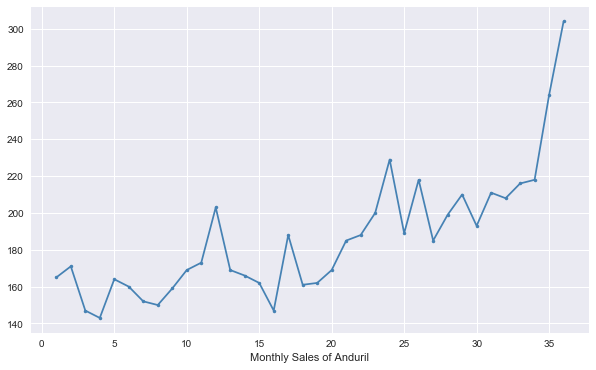

In [8]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.set_xlabel( "Monthly Sales of Anduril")

plt.show()

## Level

The simplest approach to forecasting models the data as having a *level* that is subjected to unexplained shocks (or *error*). You can think of the level as the value about which the variable hovers...why it's 139 and not 5348. )It's kind of interesting that anything we can't explain or don't care about is called "error" but there you go):

$forecast_{t} = level_{t-1} + \epsilon$

What value should we use for the $level$? The dirt simplest approach is to just use the mean of all the past values. Sometimes this level is adjusted by a domain expertise, "we've sold 100 sprockets on average over the last 12 months and we think that the market is going to expand 10% this year so 110." This approach is used a *lot*. By really big publically traded companies and thus more often than it really should be. However, if your problem really is that simple you shouldn't be looking for something more complicated "just because".

Let's see how this works for Anduril sales:

In [9]:
average = sword[ "sales"].mean()
print(average)

186.027777778


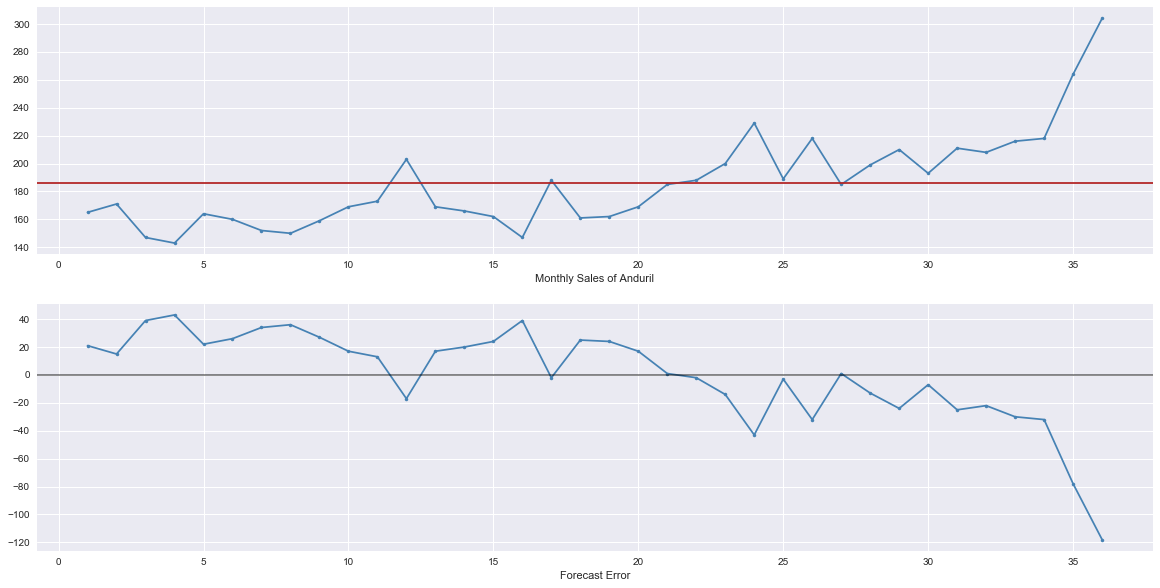

In [10]:
figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=average, xmin=0, xmax=40, c="firebrick")
axes.set_xlabel( "Monthly Sales of Anduril")

axes = figure.add_subplot(2, 1, 2)

axes.plot( sword["t"], average - sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

As with linear and logistic regression, the observation that our errors--residuals--have a pattern suggests that something is wrong with our model. In this case, if we use the average and compare the prediction against past sales, we see that the predicted sales are too high in the early years and too low in the later years.

The problem, more or less, with this simple (simplistic?) approach is that it treats data from 2 years ago the same as data from 6 months ago. What if we want more recent data to have greater weight in our estimate of the level?

## Simple Exponential Smoothing

We have a general sense that the latest information is more important than past information. In that case, we can use something called *simple exponential smoothing* or SES to estimate our level. Our forecast takes the following form:

$level_{t} = level_{t-1} + \alpha (x_{t-1} - level_{t-1})$

This says that our forecast for the level at t is equal to the previous plus some percentage, $\alpha$, times the error in that forecast. In general, we keep the *forecast* and the *level* distinct but right now they're the same. You'll need to watch out for this later.

This sounds easy enough except that we need to have some value for $level_0$. We also need to pick $\alpha$.

### Initial Level

Depending on how noisy the data is, you can pick either the very first observation or an average over the first observations. For example, the average of the first 12 values is:

In [11]:
sword[ "sales"][ 0:12].mean()

163.0

### $\alpha$

Picking an initial $\alpha$ doesn't much matter. Later, we'll see what $\alpha$ does in which case starting with a value of 0.5 seems like a good idea. However, in general, the value of $\alpha$ is something that can be optimized using either a gradient descent, evolutionary algorithms or just plain old grid search.

In [12]:
alpha = 0.5

In [13]:
n = len( sword[ "sales"])
level = sword[ "sales"][ 0:12].mean()
ses = [level]
for i in range( 1, n):
    level = level + alpha * (sword["sales"][ i - 1] - level)
    ses.append( level)

The line:

`level = level + alpha * (sword["sales"][ i - 1] - level)`

contains the update. We set the level as the current value of the level (computer programs need subscripts!) plus $\alpha$ times the difference in the actual sales which is the forecast error. The whole thing is a little confusing and the multiple subscripts in the formula doesn't help. The general process is this:

1. Based on the values in t-1, make a forecast for t.
2. Calculate your forecast error.
3. Calculate the values (level in this case) that you will need to make a forecast for t+1.

In the current problem, for t=1, this works out as:

1. We have $level_0 = 163.0$ so our forecast for $t=1$ is 163. 
2. We actually sold 165 so our forecast error is 2.
3. Our $level_1 = level_0 + \alpha error = 163 + 0.5 \times 2 = 163 + 1 = 164$.

We then repeat the process for t=2:

1. We have $level_1 = 164.0$ so our forecast for $t=2$.
2. Actual sales was 171 so our forecast error is 7.0.
3. Our $level_2 = 164.0 + 0.5 \times 7.0 = 164.0 + 3.5 = 167.5$.

It can be a little confusing. We start out with a forecast for the *current* period and check our error to compute the basis for a forecast for the *next* period.

In [14]:
ses

[163.0,
 164.0,
 167.5,
 157.25,
 150.125,
 157.0625,
 158.53125,
 155.265625,
 152.6328125,
 155.81640625,
 162.408203125,
 167.7041015625,
 185.35205078125,
 177.176025390625,
 171.5880126953125,
 166.79400634765625,
 156.89700317382812,
 172.44850158691406,
 166.72425079345703,
 164.36212539672852,
 166.68106269836426,
 175.84053134918213,
 181.92026567459106,
 190.96013283729553,
 209.98006641864777,
 199.49003320932388,
 208.74501660466194,
 196.87250830233097,
 197.93625415116549,
 203.96812707558274,
 198.48406353779137,
 204.74203176889569,
 206.37101588444784,
 211.18550794222392,
 214.59275397111196,
 239.29637698555598]

In [15]:
sword[ "ses"] = pd.Series( ses)

In [16]:
print(sword)

     t  sales         ses
0    1    165  163.000000
1    2    171  164.000000
2    3    147  167.500000
3    4    143  157.250000
4    5    164  150.125000
5    6    160  157.062500
6    7    152  158.531250
7    8    150  155.265625
8    9    159  152.632812
9   10    169  155.816406
10  11    173  162.408203
11  12    203  167.704102
12  13    169  185.352051
13  14    166  177.176025
14  15    162  171.588013
15  16    147  166.794006
16  17    188  156.897003
17  18    161  172.448502
18  19    162  166.724251
19  20    169  164.362125
20  21    185  166.681063
21  22    188  175.840531
22  23    200  181.920266
23  24    229  190.960133
24  25    189  209.980066
25  26    218  199.490033
26  27    185  208.745017
27  28    199  196.872508
28  29    210  197.936254
29  30    193  203.968127
30  31    211  198.484064
31  32    208  204.742032
32  33    216  206.371016
33  34    218  211.185508
34  35    264  214.592754
35  36    304  239.296377


Let's plot these two series:

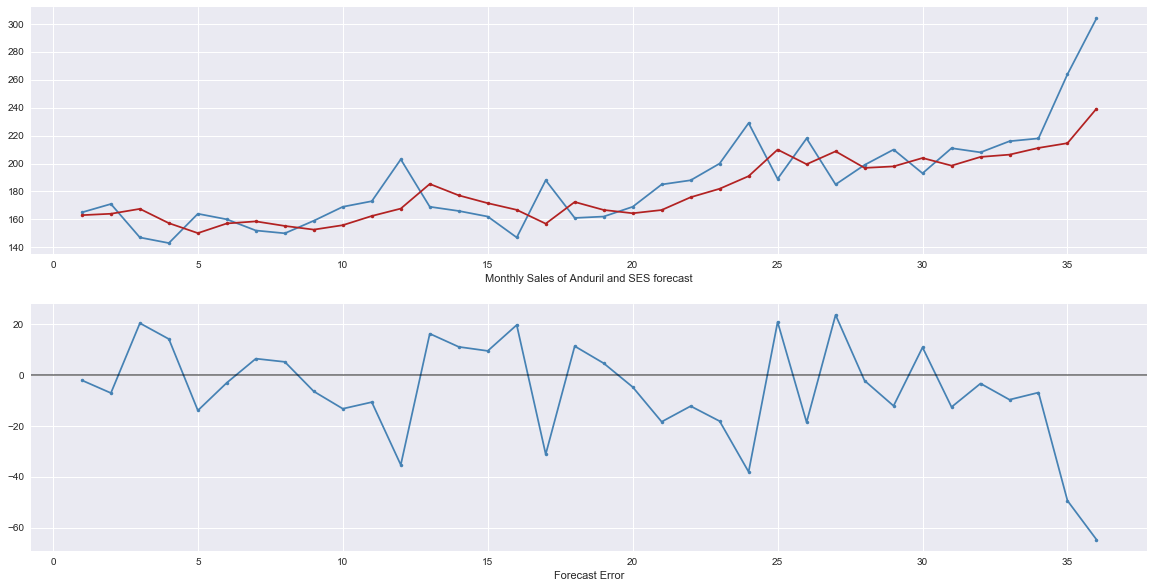

In [17]:
figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "ses"], color="firebrick", marker=".")
axes.set_xlabel( "Monthly Sales of Anduril and SES forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( sword["t"], sword[ "ses"] - sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

If you look closely, the red line is a dampened version of the blue (actual) line shifted forward slightly with large errors being built into the base of the line (what we're calling the level). It's not completely awfulbut we're only looking at the past. What is our forecast for t=37?

In [18]:
sword[ "ses"][ 35] + 0.5 * (sword[ "sales"][ 35] - sword[ "ses"][ 35])

271.64818849277799

Let's see what role $\alpha$ has to play here. If $\alpha$ is zero, then we take none of our error into account and we look only at the level for our for cast. This essentially has us use whatever we set to $level_0$ as our forecast. If we take $\alpha$ to be 1.0, then we add our entire forecast error to our next forecast:

In [19]:
def ses_forecast( level_0, alpha, actual):
    n = len( actual)
    ses = [level_0]
    for i in range( 1, n):
        level = ses[ i - 1] + alpha * (actual[ i - 1] - ses[ i - 1])
        ses.append( level)
    return pd.Series( ses)

In [20]:
sword[ "ses0"] = ses_forecast( 163.0, 0.0, sword[ "sales"])
sword[ "ses1"] = ses_forecast( 163.0, 1.0, sword[ "sales"])

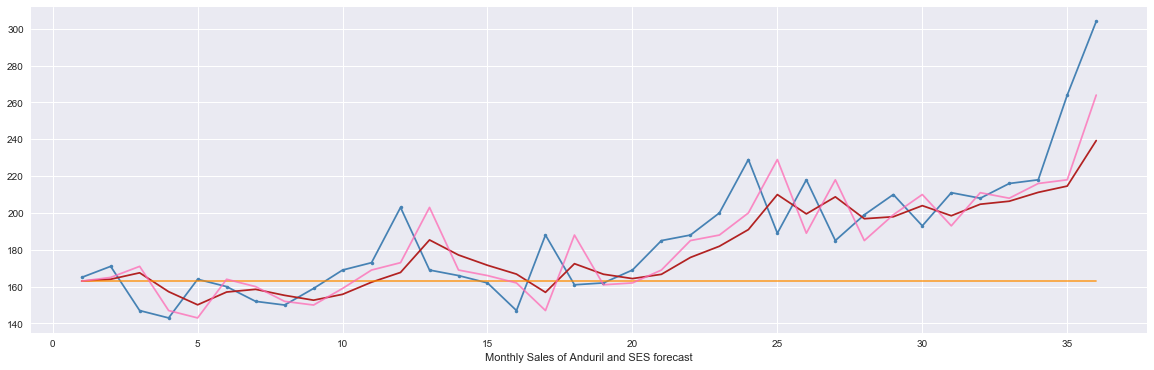

In [21]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "ses"], color="firebrick")
axes.plot( sword["t"], sword[ "ses0"], color="darkorange", alpha=0.75)
axes.plot( sword["t"], sword[ "ses1"], color="hotpink", alpha=0.75)

axes.set_xlabel( "Monthly Sales of Anduril and SES forecast")

plt.show()

So $\alpha$ gives the weight to *old* or earlier, demand points. With $\alpha=0.0$, we gave *all* the weight to the first point (our initial $level_0$) whereas with $\alpha = 1.0$, we gave weight to just the last point (which caused our prediction to be simply the last period's sales).

Finally, we come to a bit of a problem. We will get the same prediction for t=37, t=38, t=39, etc...all the same value. But that doesn't seem reasonable given our data, there seems to be an upward *trend*.

## Holt's Trend Corrected Smoothing

How can we tell if we actually have a trend? One way is to do linear regression on the data with $y$ as the value and $x$ as...what should $x$ be?

Time.

Yup, we're going to regress "sales ~ t".

In [22]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

In [23]:
result = lm( "sales ~ t", data=sword)

In [24]:
def describe_fit( result):
    formula = result[ "formula"]
    print("regression: ", formula)
    print("n: ", result[ "n"])
    print("----------")
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print(variable.strip() + ": ", coefficient)
    print("----------")
    print("sigma", result[ "sigma"])
    print("R^2", result[ "r^2"])

In [25]:
describe_fit( result)

regression:  sales ~ t
n:  36
----------
intercept:  139.063492063
t:  2.53861003861
----------
sigma 21.2034477749
R^2 0.620912599592


The results say that with each month, we add 2.5 orders. Ideally, we should do some kind of statistical test on this but bootstrapping time series data is a bit weird (as is the concept of a sampling distribution...are we sampling alternative universes?). For right now, we're going to go with these results.

Our general forecasting model is:

$forecast_{t} = level_{t} + trend_{t} + \epsilon$

Holt's Trend Corrected Exponential Smoothing introduces two things. First, we use the trend to update our forecast and, second, we also have to update our estimate of the trend:

$level_{t} = (level_{t-1} + trend_{t-1}) + \alpha (x_{t-1} - (level_{t-1} + trend_{t-1}))$

$trend_{t} = trend_{t-1} + \gamma \alpha (x_{t-1} - (level_{t-1} + trend_{t-1}))$

$forecast_{t} = level_t + trend_t$

Let's do that:

In [26]:
def holts_one_step( alpha, gamma, level, trend, error):
    this_trend = trend + gamma * alpha * error
    this_level = level + trend + alpha * error
    return (this_trend, this_level)

def holts_forecast( level_0, trend_0, alpha, gamma, actual):
    n = len( actual)
    trend, level = trend_0, level_0
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        forecast = level + trend
        forecasts.append( forecast)
        
        error = actual[ i] - forecast

        trend, level = holts_one_step( alpha, gamma, level, trend, error)
        
        trends.append( trend)
        levels.append( level)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends))

Where should we start? We don't need to estimate our starting values from the whole data series. We can, for example, use only the first 12 or 18 months:

In [27]:
describe_fit( lm( "sales ~ t", data = sword.ix[0:17]))

regression:  sales ~ t
n:  18
----------
intercept:  155.882352941
t:  0.836945304438
----------
sigma 14.480846572
R^2 0.0918612318174


We then use the intercept ($\beta_0$) for our estimate of $level_0$ and our slope ($\beta_1$) for our estimate of $trend_0$.

In [28]:
holts, levels, trends = holts_forecast( 155.88, 0.8369, 0.5, 0.5, sword[ "sales"])

In [29]:
holts

0     156.716900
1     163.766125
2     172.099206
3     157.990945
4     145.189079
5     153.990875
6     157.894055
7     154.372131
8     150.518136
9     155.211605
10    166.005438
11    175.150995
12    201.686025
13    189.782033
14    176.384529
15    164.089645
16    146.169792
17    168.167417
18    163.874375
19    161.759261
20    166.011888
21    180.885230
22    191.600593
23    205.058127
24    232.272362
25    215.061389
26    221.690555
27    199.332500
28    195.070347
29    202.171684
30    194.929431
31    204.325947
32    208.442718
33    216.390424
34    221.766671
35    258.013127
dtype: float64

In [30]:
levels

0     160.858450
1     167.383062
2     159.549603
3     150.495473
4     154.594539
5     156.995438
6     154.947028
7     152.186066
8     154.759068
9     162.105802
10    169.502719
11    189.075497
12    185.343012
13    177.891017
14    169.192265
15    155.544823
16    167.084896
17    164.583708
18    162.937188
19    165.379630
20    175.505944
21    184.442615
22    195.800297
23    217.029063
24    210.636181
25    216.530694
26    203.345278
27    199.166250
28    202.535173
29    197.585842
30    202.964716
31    206.162974
32    212.221359
33    217.195212
34    242.883336
35    281.006563
dtype: float64

In [31]:
trends

0      2.907675
1      4.716144
2     -1.558658
3     -5.306394
4     -0.603664
5      0.898617
6     -0.574896
7     -1.667929
8      0.452537
9      3.899635
10     5.648276
11    12.610527
12     4.439021
13    -1.506487
14    -5.102620
15    -9.375031
16     1.082521
17    -0.709333
18    -1.177927
19     0.632258
20     5.379286
21     7.157978
22     9.257830
23    15.243298
24     4.425208
25     5.159861
26    -4.012778
27    -4.095903
28    -0.363490
29    -2.656411
30     1.361232
31     2.279745
32     4.169065
33     4.571459
34    15.129791
35    26.626510
dtype: float64

In [32]:
sword[ "holts"] = holts
sword[ "holts_level"] = levels
sword[ "holts_trend"] = trends

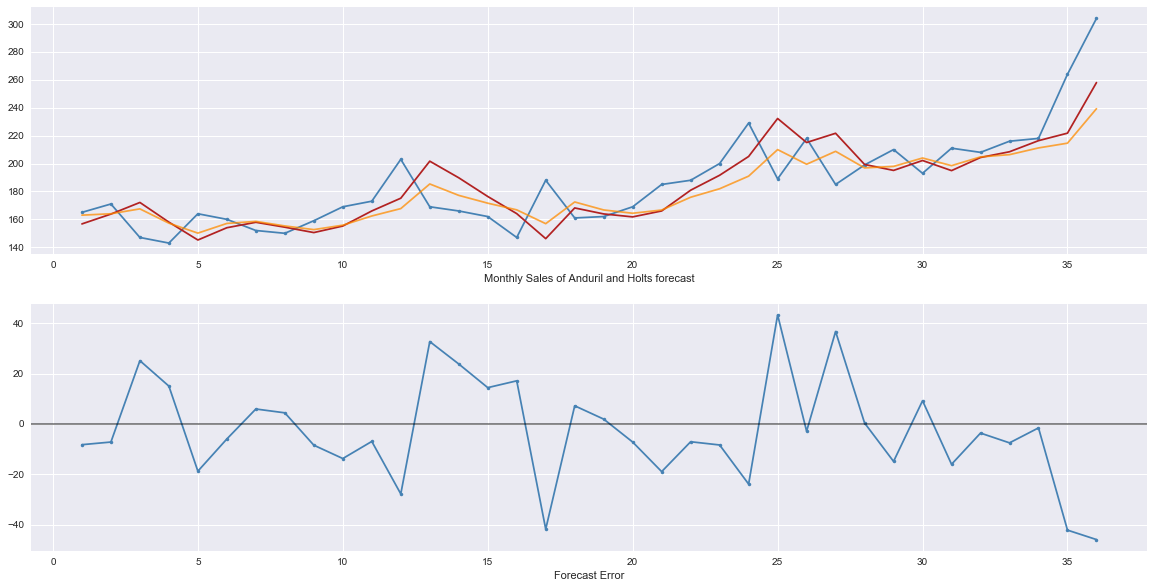

In [33]:
figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "holts"], color="firebrick")
axes.plot( sword["t"], sword[ "ses"], color="darkorange", alpha=0.75)
axes.set_xlabel( "Monthly Sales of Anduril and Holts forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( sword["t"], sword[ "holts"] - sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

In [34]:
print(((sword[ "sales"] - sword[ "ses"])**2).sum())

15346.8594496


In [35]:
print(((sword[ "sales"] - sword[ "holts"])**2).sum())

15315.3153932


Where Holts differs most from SES is when we start forecasting later periods:

In [36]:
# t = 37 (index 36)
print(sword[ "holts_level"][35] + sword[ "holts_trend"][35])

307.63307299


In [37]:
# t = 38 (index 37)
print(sword[ "holts_level"][35] + 2.0 * sword[ "holts_trend"][35])

334.25958253


In [38]:
# t = 39 (index 38)
print(sword[ "holts_level"][35] + 3.0 * sword[ "holts_trend"][35])

360.886092069


### Picking $\alpha$ and $\gamma$

So how do we pick $\alpha$ and $\gamma$? Well...there are a variety of ways to do this. One involves optimization and as with any optimization problem, we need a loss function. For this particular problem we'll go with Sum of Squared Errors (SSE or MSE, doesn't matter) but as we've mentioned many times, your problem might be different. For example, you might have a bigger problem with overestimating or underestimating.

We can see what our SSE is:

In [39]:
sse = ((sword[ "holts"] - sword[ "sales"])**2.0).sum()
print(sse)

15315.3153932


Above we used $\alpha$ and $\gamma$ both set to 0.5. Let's do a gridsearch:

In [40]:
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(alpha, " -", end=' ') 
    for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        holts, _, _ = holts_forecast( 155.88, 0.8369, alpha, gamma, sword[ "sales"])
        sse = ((holts - sword[ "sales"])**2.0).sum()
        print(int( sse), end=' ')
    print()

0.1  - 17985 16251 15599 15601 15989 16614 17408 18359 19486 
0.2  - 15879 15797 16547 17715 19149 20739 22313 23646 24517 
0.3  - 15329 15827 16788 17796 18574 18922 18797 18328 17717 
0.4  - 14843 15348 15962 16341 16389 16200 15950 15783 15771 
0.5  - 14424 14809 15153 15298 15315 15343 15481 15765 16185 
0.6  - 14193 14525 14815 15021 15240 15552 15985 16526 17147 
0.7  - 14210 14583 14957 15338 15793 16360 17037 17810 18664 
0.8  - 14507 15003 15554 16176 16916 17796 18820 19992 21327 
0.9  - 15119 15824 16647 17610 18759 20122 21729 23620 25849 


It looks like $\alpha=0.6$ and $\gamma = 0.1$ are the best. Because your gridsearch is only as good as the granularity of your grid, we should look around these values in 0.01 increments. If we do, we'll find that $\alpha=0.66$ and $\gamma = 0.05$ are about the best.

In [41]:
holts, levels, trends = holts_forecast( 155.88, 0.8369, 0.66, 0.05, sword[ "sales"])
sword[ "holts"] = holts
sword[ "holts_level"] = levels
sword[ "holts_trend"] = trends

In [42]:
sse = ((sword[ "holts"] - sword[ "sales"])**2.0).sum()
print(sse)

14097.7038484


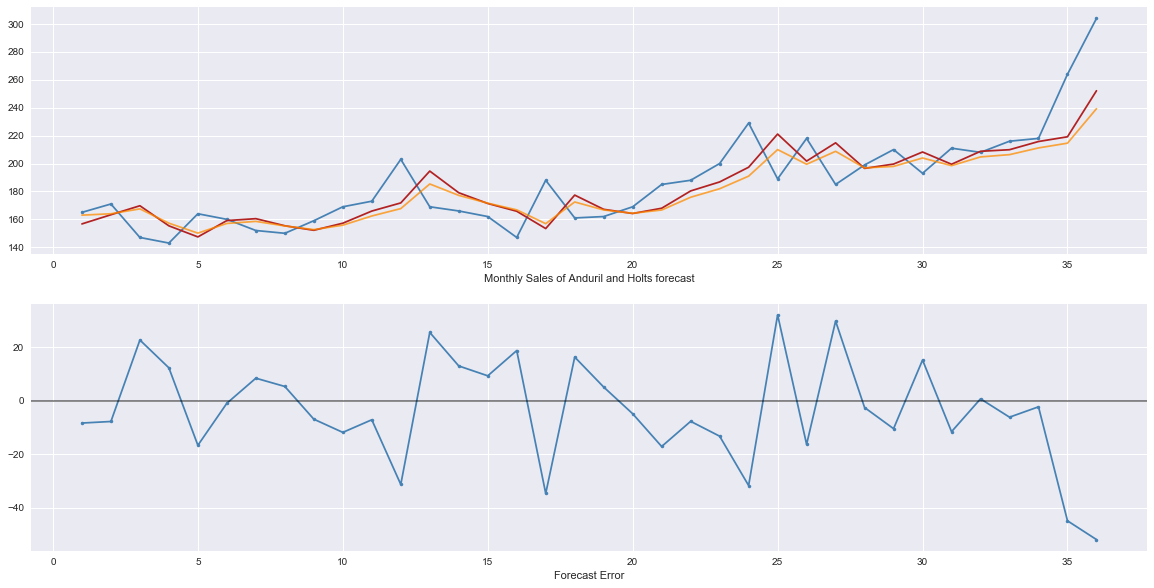

In [43]:
figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "holts"], color="firebrick")
axes.plot( sword["t"], sword[ "ses"], color="darkorange", alpha=0.75)
axes.set_xlabel( "Monthly Sales of Anduril and Holts forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( sword["t"], sword[ "holts"] - sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

## Finetuning by looking for autocorrelations

When we looked at linear regression, we suggested plotting residuals to see if there was a pattern that would suggest an underlying problem with our data (or pattern what we needed to explain). We can do the same thing with our forecasting model. What we're looking for is patterns in our residuals associated with $t$. More concertely, do we underestimate every December and over estimate every March? In time series analysis such patterns are called *seasonality*.

We start by calculating our one step errors:

In [44]:
errors = sword[ "sales"] - sword[ "holts"]

In [45]:
errors

0      8.283100
1      7.706012
2    -22.744497
3    -12.347101
4     16.595468
5      0.888291
6     -8.481463
7     -5.387291
8      6.842508
9     11.774837
10     7.063259
11    31.228235
12   -25.586205
13   -13.058770
14    -9.368502
15   -18.804651
16    34.607612
17   -16.374270
18    -5.167759
19     4.812991
20    17.047617
21     7.644819
22    13.195589
23    31.647396
24   -32.123354
25    16.254662
26   -29.833217
27     2.481401
28    10.386485
29   -15.268541
30    11.512612
31    -0.761712
32     6.090154
33     2.218814
34    44.829337
35    51.837547
dtype: float64

And then mean-centering (but *not* mean-*scaling*) them:

In [46]:
mean_error = errors.mean()
print(mean_error)

3.60115039604


In [47]:
deviations = errors - mean_error

In [48]:
deviations

0      4.681950
1      4.104861
2    -26.345647
3    -15.948252
4     12.994317
5     -2.712860
6    -12.082614
7     -8.988442
8      3.241358
9      8.173686
10     3.462109
11    27.627085
12   -29.187355
13   -16.659920
14   -12.969653
15   -22.405801
16    31.006462
17   -19.975420
18    -8.768909
19     1.211841
20    13.446467
21     4.043669
22     9.594438
23    28.046245
24   -35.724504
25    12.653512
26   -33.434367
27    -1.119749
28     6.785334
29   -18.869691
30     7.911462
31    -4.362862
32     2.489004
33    -1.382337
34    41.228187
35    48.236397
dtype: float64

So what does this all mean? We define our *error* as the actual swords sold less our prediction. On average, we sell 2.88 (almost 3) swords more than we predict we'll sell. After we mean center our errors, we have how many more swords above or below that average our error was. For Month 1, our mean centered error was 5.18 swords which means we sold 5.18 more swords than our average error which would be approximately 8.

If we look at Month 27, our forecast error was 39.6 swords less than the average which means we sold 39.6 fewer swords than our usual forecast error (of 3 more swords). Weird but true. Luckily, these numbers are not our final goal because analyzing them would make you go crazy. We're going to let a computer do that.

As the name *autocorrelation* suggests, we want to see if these errors are correlated with themselves at different offests (we'll try 12). In essence, we want to know if errors this month are correlated with errors 1, 2, 3,..., 12 months ago. How do we do that? Creating a copy of the these mean-centered errors and *shifting* them one month, two months, three months, etc. What this allows us to do is to see if Month 30's error is correlated with Month 29's, then Month 28's, etc.

There's no general limit to the autocorrelation you can look for except how much data you have and the granularity. For example, if we had daily data, we could look for weekday, week and monthly autocorrelations (maybe Monday is always a good day or the 15th of the month).

Here's some code that:

1. shifts a copy of the deviations by N periods.
2. pads with zeros.
3. returns the correlation coefficient for between the deviations series and the version shifted N periods.

In [49]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 -0.0389027710409
2 0.0650793306201
3 -0.0159942425727
4 -0.195524422373
5 0.148974337739
6 -0.220770227082
7 0.180217467019
8 -0.408091741623
9 -0.00339609076098
10 -0.14214191743
11 0.0830362156183
12 0.639107653112


The rule of thumb is that we should "worry" about correlations larger than:

$cutoff = \frac{2}{\sqrt{N}}$

which in our case is:

In [50]:
cutoff = 2.0 / np.sqrt( len( sword[ "sales"]))
print(cutoff)

0.333333333333


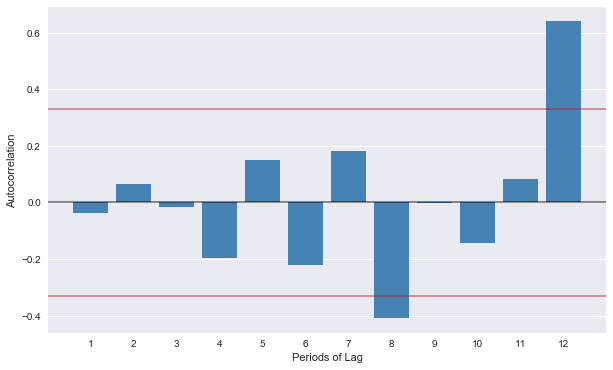

In [51]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="steelblue", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

Based on this, it looks like we have two errors that are autocorrelated with themselves...an eight (8) month lag and a 12 month lag. The last one makes sense...we make the same error every December by not allowing for the holidays. The lag for September is not quite as obvious but we can easily include it anyway.

## Holt-Winters

Multiplicative Holt-Winters Smoothing allows us to add *seasonality* adjustment factors to our forecasting model. The general forecasting model is:

$forecast_{t} = (level_{t} + trend_{t}) \times seasonality_t \times other + \epsilon$

where "other" is anything else. Notice that $seasonality_t$ is a multiplicative adjustment factor. We now have 3 components that we need to estimate in any given period: level, trend and seasonality.

$level_{t} = level_{t-1} + trend_{t-1} + \alpha \frac{error}{seasonality_{t-1}}$

$trend_{t} = trend_{t-1} + \gamma \alpha \frac{error}{seasonality_{t-1}}$

$seasonality_{t} = seasonality_{t-1} + \delta (1 - \alpha) \frac{error}{level_{t-1} + trend_{t-1}}$

The key thing is that any time you're dealing with actual data (in this case, $error$) you need to *de*seasonalize it by dividing by your current estimate of the seasonality factor. This is why the forecast for $x_{t}$ above multiplies by the factor (it is adjusting a trended level *into* the "real world") and the update equations divide by it (it is adjusting a real world error *into* a world without seasonality).

The problem now is to identify and separate what is level, trend and seasonality in our data. For this particular problem, we need one level, one trend and 12 seasonal adjustment factors. The basic idea is this:

1. Identify the seasonality.
2. Remove the seasonality from the historical data.
3. Identify the level and trend on the deseasonalized data.

This particular approach requires at least two cycles of data. For example, if you have identified a weekly cycle, you need at least two weeks of data. If you have identified a summer cycle or December (annual) cycle, you need at least two years of data. Oddly, this is the kind of stuff that's a bit easier to do in a spreadsheet.

### 12 Month Moving Average (MA)

In order to identify the seasonality, we're going to smooth the data. This is accomplished using a *moving average*. We're using *centered* moving averages so that the estimate goes into the center of the range of values averaged (the alternative is right moving averages because the value goes on the right of the values averaged).

Because our *window* is 12 months (periods) which doesn't have a "center", we need to calculate two moving averages one offset by -6 and +5 and one offset by -5 and +6 and average those. This is a "2 x 12 MA".

In [52]:
ma_sales = pd.rolling_mean( sword[ "sales"], window=12, center=True)
ma_sales

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     163.000000
7     163.333333
8     162.916667
9     164.166667
10    164.500000
11    166.500000
12    166.583333
13    167.416667
14    169.000000
15    171.166667
16    172.750000
17    175.000000
18    177.166667
19    178.833333
20    183.166667
21    185.083333
22    189.416667
23    191.250000
24    193.916667
25    198.000000
26    201.250000
27    203.833333
28    206.333333
29    211.666667
30    217.916667
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
Name: sales, dtype: float64

In [53]:
shifted_ma = []
for i in range( 0, 36):
    current = None
    if 5 < i < 31:
        current = sword["sales"][ i-5:i+7].mean()
    shifted_ma.append( current)
shifted_ma_sales = pd.Series( shifted_ma)

print(shifted_ma_sales)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     163.333333
7     162.916667
8     164.166667
9     164.500000
10    166.500000
11    166.583333
12    167.416667
13    169.000000
14    171.166667
15    172.750000
16    175.000000
17    177.166667
18    178.833333
19    183.166667
20    185.083333
21    189.416667
22    191.250000
23    193.916667
24    198.000000
25    201.250000
26    203.833333
27    206.333333
28    211.666667
29    217.916667
30    220.545455
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
dtype: float64


In [54]:
smoothed_sales = (ma_sales + shifted_ma_sales) / 2.0
smoothed_sales[ 30] = None
smoothed_sales

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     163.166667
7     163.125000
8     163.541667
9     164.333333
10    165.500000
11    166.541667
12    167.000000
13    168.208333
14    170.083333
15    171.958333
16    173.875000
17    176.083333
18    178.000000
19    181.000000
20    184.125000
21    187.250000
22    190.333333
23    192.583333
24    195.958333
25    199.625000
26    202.541667
27    205.083333
28    209.000000
29    214.791667
30           NaN
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
dtype: float64

If we divide sales by our 2 x 12 MA, we will get our seasonality estimates:

In [55]:
seasonal_factor_estimate = sword[ "sales"] / smoothed_sales
seasonal_factor_estimate

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.931563
7     0.919540
8     0.972229
9     1.028398
10    1.045317
11    1.218914
12    1.011976
13    0.986871
14    0.952474
15    0.854858
16    1.081237
17    0.914340
18    0.910112
19    0.933702
20    1.004752
21    1.004005
22    1.050788
23    1.189096
24    0.964491
25    1.092048
26    0.913392
27    0.970337
28    1.004785
29    0.898545
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
dtype: float64

Our initial seasonal factor estimates are just the ratio of the actual raw sales to the smoothed sales. We now have 24 seasonal factor estimates but we only need 12. We're simply going to average the seasonal factor estimates to create our seasonal factor adjustments.

Basically, we need to pick out the indices that are multiples of 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11:

In [56]:
initial_seasonal_factors = [
    seasonal_factor_estimate[[0, 12, 24]].mean(),
    seasonal_factor_estimate[[1, 13, 25]].mean(),
    seasonal_factor_estimate[[2, 14, 26]].mean(),
    seasonal_factor_estimate[[3, 15, 27]].mean(),
    seasonal_factor_estimate[[4, 16, 28]].mean(),
    seasonal_factor_estimate[[5, 17, 29]].mean(),
    seasonal_factor_estimate[[6, 18, 30]].mean(),
    seasonal_factor_estimate[[7, 19, 31]].mean(),
    seasonal_factor_estimate[[8, 20, 32]].mean(),
    seasonal_factor_estimate[[9, 21, 33]].mean(),
    seasonal_factor_estimate[[10, 22, 34]].mean(),
    seasonal_factor_estimate[[11, 23, 35]].mean()]
initial_seasonal_factors

[0.98823339924446252,
 1.0394595142086607,
 0.93293329171244777,
 0.91259775591054715,
 1.0430106047420362,
 0.90644245153667458,
 0.92083758937691518,
 0.92662094367181047,
 0.98849075287229571,
 1.0162014531884298,
 1.0480526558060541,
 1.2040049076184032]

In [57]:
from copy import deepcopy

In [58]:
seasonal_factors = pd.Series( initial_seasonal_factors + deepcopy( initial_seasonal_factors) + deepcopy(initial_seasonal_factors))

In [59]:
sword[ "seasonal"] = seasonal_factors

Now we can create our deseasonalized data. Notice that to create *de* seasonalized data we are *dividing* by the seasonal adjustment factor. That is...if sales if lower than normal in January in order to bring them up to a value that is only the trend for January, we divide by the adjustment. Later it works the other way, we predict a non-seasonal January and then adjust it down.

In [60]:
sword[ "deseasonalized"] = sword[ "sales"] / sword[ "seasonal"]
print(sword[["sales", "deseasonalized"]])

    sales  deseasonalized
0     165      166.964606
1     171      164.508572
2     147      157.567536
3     143      156.695542
4     164      157.237136
5     160      176.514240
6     152      165.067110
7     150      161.878491
8     159      160.851277
9     169      166.305607
10    173      165.068042
11    203      168.603964
12    169      171.012233
13    166      159.698380
14    162      173.645856
15    147      161.078634
16    188      180.247448
17    161      177.617454
18    162      175.926789
19    169      182.383100
20    185      187.154002
21    188      185.002688
22    200      190.830107
23    229      190.198560
24    189      191.250367
25    218      209.724378
26    185      198.299280
27    199      218.058831
28    210      201.340235
29    193      212.920301
30    211      229.139212
31    208      224.471507
32    216      218.514942
33    218      214.524393
34    264      251.895741
35    304      252.490665


Let's see the differences in the data:

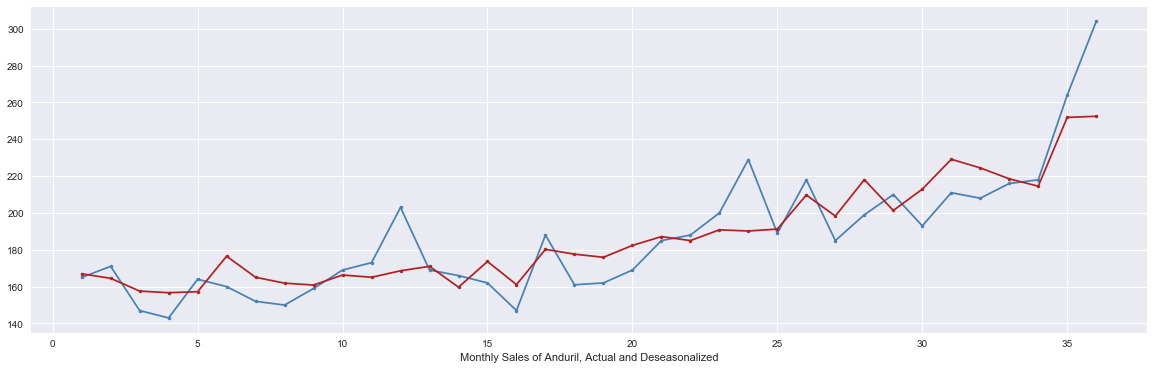

In [61]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "deseasonalized"], color="firebrick", marker=".")
axes.set_xlabel( "Monthly Sales of Anduril, Actual and Deseasonalized")

plt.show()

Now we fit our deseasonaled data with a trend line:

In [62]:
describe_fit( lm( "deseasonalized ~ t", data=sword))

regression:  deseasonalized ~ t
n:  36
----------
intercept:  144.423542254
t:  2.29045000494
----------
sigma 11.4295136244
R^2 0.821070411892


Now we have a $level_0 = 144.3$ and $trend_0 = 2.29$ for our Holts-Winters plus the seasonal adjustment factors. Everything is basically the same as Holt except we're going to multiply by the seasonal adjustment factor.

In [63]:
def holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor):
    this_factor = factor + delta * (1.0 - alpha) * error / ( level + trend)
    this_trend = trend + (gamma * alpha * error) / factor
    this_level = level + trend + (alpha * error) / factor
    return (this_factor, this_trend, this_level)

def holt_winters_forecast( level_0, trend_0, alpha, gamma, delta, actual, seasonality):
    n = len( actual)
    trend, level, factor = trend_0, level_0, seasonality[ 0]
    factors = []
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        if i < 12:
            factor = seasonality[ i]
        else:
            factor = factors[ i - 12]

        forecast = (level + trend) * factor
        forecasts.append( forecast)
        
        error = actual[ i] - forecast

        factor, trend, level = holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor)
        
        factors.append( factor)
        trends.append( trend)
        levels.append( level)
        
            
        print(forecast, error, level, trend, factor)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends), pd.Series( factors))

We should, of course, grid search the $\alpha$ and $\gamma$ to find the best values after starting with initial guesses. I'm going to skip ahead and use $\alpha = 0.30$ and $\gamma = 0.23$ and $\delta = 0.0$.

In [64]:
winters, levels, trends, factors = holt_winters_forecast( 144.42, 2.2095, 0.3, 0.23, 0.0, sword[ "sales"], initial_seasonal_factors)

144.904169215 20.0958307855 152.730031757 3.61262230416 0.988233399244
162.511859241 8.48814075925 158.792429346 4.17607061974 1.03945951421
152.038739119 -5.03873911894 161.348210768 3.80340410403 0.932933291712
150.716993117 -7.71699311678 162.614793013 3.21993507662 0.912597755911
172.967380032 -8.96738003225 163.255450375 2.62670120209 1.04301060474
150.362624141 9.63737585871 169.071777959 3.36031527006 0.906442451537
158.78195306 -6.78195306035 170.222598372 2.85213145289 0.920837589377
160.374669476 -10.374669476 169.715858148 2.07959096724 0.926620943672
169.818212836 -10.818212836 168.51219751 1.32444309811 0.988490752872
172.588240991 -3.58824099097 168.777330672 1.08080181261 1.01620145319
178.02026686 -5.02026686027 168.421105394 0.750285581928 1.04805265581
203.683184964 -0.683184963896 169.001162858 0.711133114848 1.20400490762
167.715359143 1.28464085678 170.102276981 0.800828746655 0.988233399244
177.646859257 -11.6468592565 167.541687867 0.0277026386007 1.03945951421
1

In [65]:
winters

0     144.904169
1     162.511859
2     152.038739
3     150.716993
4     172.967380
5     150.362624
6     158.781953
7     160.374669
8     169.818213
9     172.588241
10    178.020267
11    203.683185
12    167.715359
13    177.646859
14    156.331063
15    154.994972
16    174.238675
17    155.694744
18    160.849317
19    163.358641
20    177.715262
21    187.150597
22    195.615647
23    229.266147
24    190.586624
25    202.451406
26    189.084557
27    186.613326
28    221.760862
29    192.631428
30    198.849411
31    207.675645
32    225.839978
33    232.750042
34    238.158887
35    287.627415
dtype: float64

In [66]:
sword[ "winters"] = winters
sword[ "winters_level"] = levels
sword[ "winters_trend"] = trends
sword[ "winters_factors"] = factors

In [67]:
sword[ "winters_factors"]

0     0.988233
1     1.039460
2     0.932933
3     0.912598
4     1.043011
5     0.906442
6     0.920838
7     0.926621
8     0.988491
9     1.016201
10    1.048053
11    1.204005
12    0.988233
13    1.039460
14    0.932933
15    0.912598
16    1.043011
17    0.906442
18    0.920838
19    0.926621
20    0.988491
21    1.016201
22    1.048053
23    1.204005
24    0.988233
25    1.039460
26    0.932933
27    0.912598
28    1.043011
29    0.906442
30    0.920838
31    0.926621
32    0.988491
33    1.016201
34    1.048053
35    1.204005
Name: winters_factors, dtype: float64

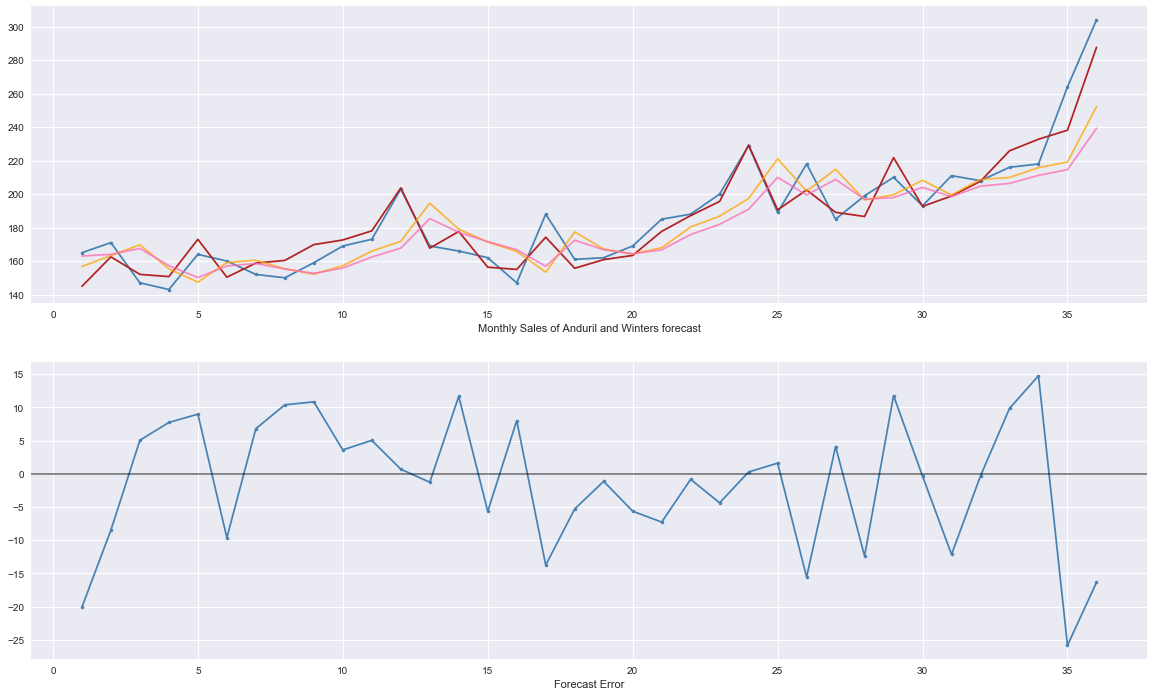

In [68]:
figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 1, 1)

axes.plot( sword["t"], sword[ "sales"], color="steelblue", marker=".")
axes.plot( sword["t"], sword[ "winters"], color="firebrick")
axes.plot( sword["t"], sword[ "holts"], color="orange", alpha=0.75)
axes.plot( sword["t"], sword[ "ses"], color="hotpink", alpha=0.75)
axes.set_xlabel( "Monthly Sales of Anduril and Winters forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( sword["t"], sword[ "winters"] - sword[ "sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

Let's compare the SSE for the three methods we used: Simple Exponential Smoothing, Holts Trend Correction and Holts Winters Seasonality Adjustment:

In [69]:
sse = ((sword[ "ses"] - sword[ "sales"])**2.0).sum()
print(sse)

15346.8594496


In [70]:
sse = ((sword[ "holts"] - sword[ "sales"])**2.0).sum()
print(sse)

14097.7038484


In [71]:
sse = ((sword[ "winters"] - sword[ "sales"])**2.0).sum()
print(sse)

3551.23829774


We can also do our forecasting:

In [72]:
# t = 37 (index 36)
print(sword[ "winters_level"][35], sword[ "winters_trend"][35], sword[ "winters_factors"][ 36 - 12])
print((sword[ "winters_level"][35] + sword[ "winters_trend"][35]) * sword[ "winters_factors"][ 36 - 12])

242.971759439 5.19419800061 0.988233399244
245.245887698


In [73]:
# t = 38 (index 37)
print(sword[ "winters_level"][35], sword[ "winters_trend"][35], sword[ "winters_factors"][ 37 - 12])
print((sword[ "winters_level"][35] + 2.0 * sword[ "winters_trend"][35]) * initial_seasonal_factors[ 37 % 12])

242.971759439 5.19419800061 1.03945951421
263.357624094


In [74]:
# t = 39 (index 38)
print(sword[ "winters_level"][35], sword[ "winters_trend"][35], sword[ "winters_factors"][ 38 - 12])
print((sword[ "winters_level"][35] + 3.0 * sword[ "winters_trend"][35]) * initial_seasonal_factors[ 38 % 12])

242.971759439 5.19419800061 0.932933291712
241.213964042
